In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
path = '/Users/aishwaryamurali/Downloads'

In [4]:
my_df = pd.read_csv(f'{path}/SpotifyFeatures.csv')
#my_df = pd.read_csv('SpotifyFeatures.csv')
print(my_df.shape)
my_df.head(2)

(232725, 18)


genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910               0.0  C#     0.346    -1.828  Major   
1       137373   0.737               0.0  F#     0.151    -5.559  Minor   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816

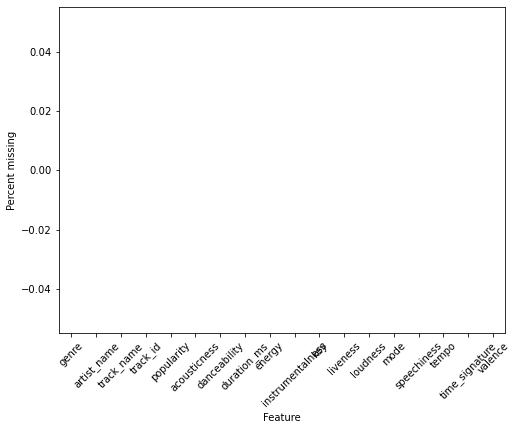

In [5]:
null_vals = my_df.isnull().sum()/len(my_df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [6]:
def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [7]:
df_2 = str_to_cat(my_df)
print(df_2.shape)
df_2.head(3)

(232725, 18)


genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910               0.0  C#     0.346    -1.828  Major   
1       137373   0.737               0.0  F#     0.151    -5.559  Minor   
2       170267   0.131               0.0   C     0.103   -13.879  Minor   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368

In [8]:
df_2 = df_2.drop(['track_name','artist_name','track_id'], axis = 1)

In [9]:
df_3,my_table = mydf_preprocessor(df_2,null_table = None)
print(df_3.shape)
df_3.head(3)

(232725, 15)


genre  popularity  acousticness  danceability  duration_ms  energy  \
0     16           0         0.611         0.389        99373   0.910   
1     16           1         0.246         0.590       137373   0.737   
2     16           3         0.952         0.663       170267   0.131   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.0    5     0.346    -1.828     1       0.0525  166.969   
1               0.0   10     0.151    -5.559     2       0.0868  174.003   
2               0.0    4     0.103   -13.879     2       0.0362   99.488   

   time_signature  valence  
0               4    0.814  
1               4    0.816  
2               5    0.368

In [10]:
my_df.head(3)

genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910               0.0  C#     0.346    -1.828  Major   
1       137373   0.737               0.0  F#     0.151    -5.559  Minor   
2       170267   0.131               0.0   C     0.103   -13.879  Minor   

   speechiness    tempo time_signature  valence  
0       0.0525  166.969            4/4    0.814  
1       0.0868  174.003            4/4    0.816  
2       0.0362   99.488            5/4    0.368

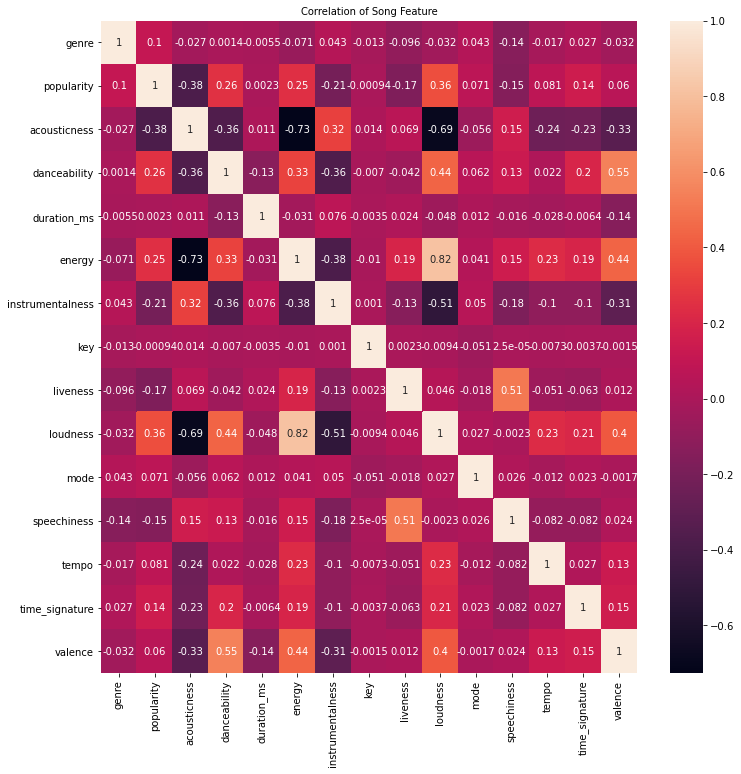

In [11]:
# Heatmap
top10=df_3#.iloc[0:10]
top10=top10[['genre','popularity','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','mode','speechiness','tempo','time_signature','valence']]
corr=top10.corr()
ax = plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True,xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.title("Correlation of Song Feature",size=10)
plt.show("Correlation of Song Feature")

In [12]:
df_3['popularity'].max()

100

In [13]:
df_3.loc[df_3['popularity'] < 50, 'popularity'] = 0 
df_3.loc[df_3['popularity'] >= 50, 'popularity'] = 1
df_3.head(3)

genre  popularity  acousticness  danceability  duration_ms  energy  \
0     16           0         0.611         0.389        99373   0.910   
1     16           0         0.246         0.590       137373   0.737   
2     16           0         0.952         0.663       170267   0.131   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.0    5     0.346    -1.828     1       0.0525  166.969   
1               0.0   10     0.151    -5.559     2       0.0868  174.003   
2               0.0    4     0.103   -13.879     2       0.0362   99.488   

   time_signature  valence  
0               4    0.814  
1               4    0.816  
2               5    0.368

In [14]:
original_data = pd.read_csv(f'{path}/SpotifyFeatures.csv')

In [15]:
df_sample = df_3
df_sample['artist_name']=original_data['artist_name']
df_sample['track_name']=original_data['track_name']
df_sample = df_sample.sample(n = 10000)

In [16]:
chosen = ['genre','acousticness','duration_ms','energy','instrumentalness','key','liveness','loudness']#,'mode','speechiness','tempo','time_signature', 'valence']
text1 = df_sample['artist_name'] + " - " + df_sample['track_name']
text2 = text1.values

# X = data_frame.drop(droppable, axis=1).values
X = df_sample[chosen].values
y = df_sample["danceability"].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text2,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="danceabbility-graph")

In [17]:
chosen = ['genre','acousticness','duration_ms','energy','instrumentalness','key','liveness','loudness']#,'mode','speechiness','tempo','time_signature', 'valence']
text1 = df_sample["artist_name"] + " - " + df_sample["track_name"]
text2 = text1.values

X = df_sample[chosen].values
y = df_sample['popularity'].values

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

pca = PCA(n_components=3)
pca.fit(X)

X = pca.transform(X)

trace = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=X[:,2],
    text=text2,
    mode="markers",
    marker=dict(
        size=8,
        color=y
    )
)

fig = go.Figure(data=[trace])
py.iplot(fig, filename="target-graph")

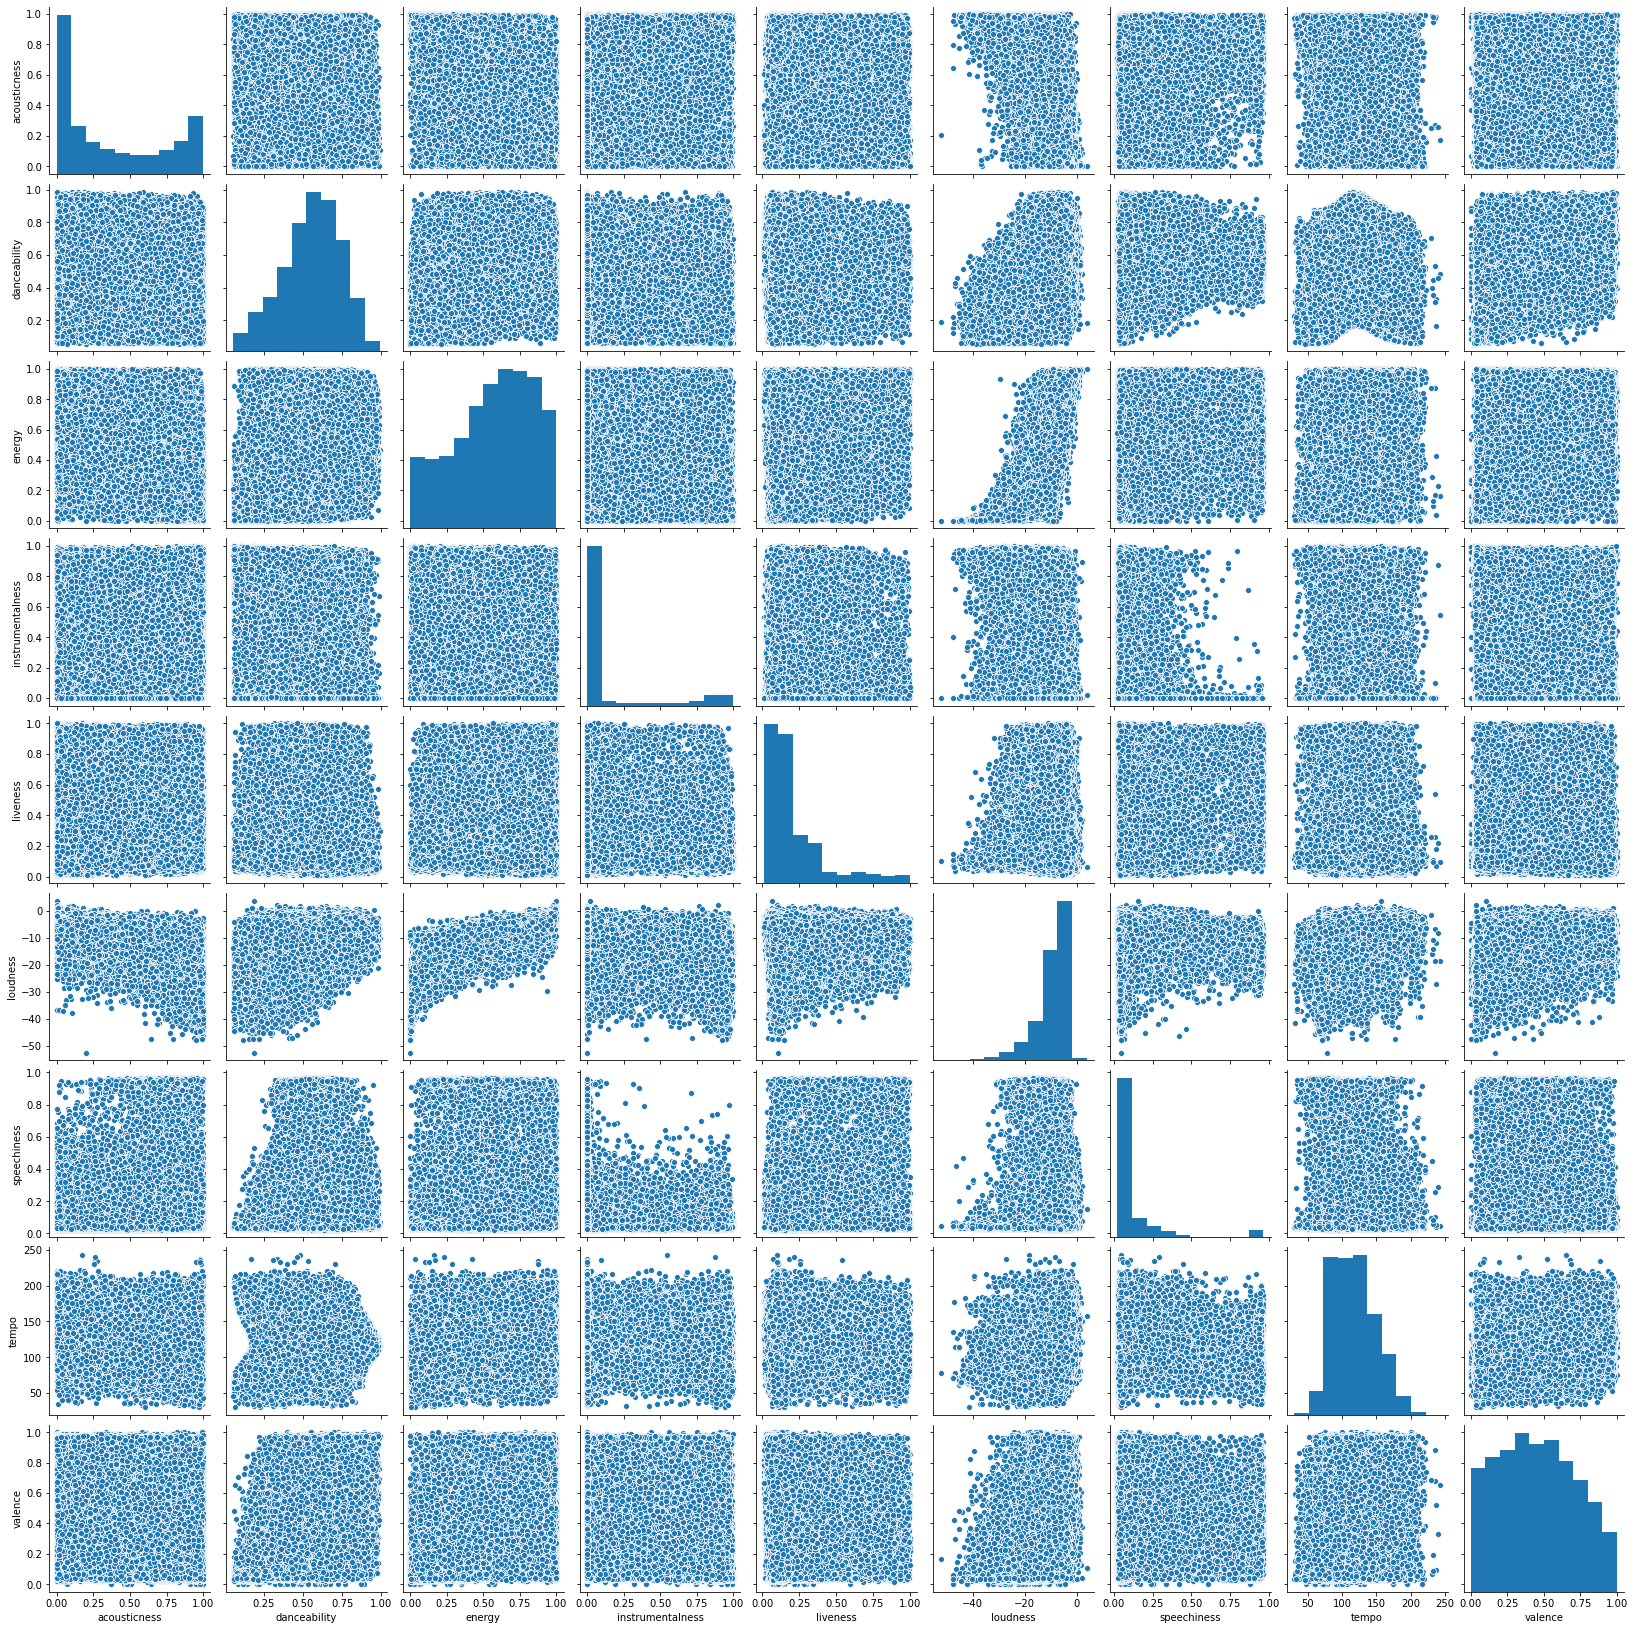

In [18]:
sns.pairplot(df_3.loc[:,df_3.dtypes == 'float64'])

In [19]:
pop = len(df_3[df_3['popularity'] == 1])
print(pop)
df_3.drop(['artist_name','track_name'],axis=1)

85017


genre  popularity  acousticness  danceability  duration_ms  energy  \
0          16           0       0.61100         0.389        99373   0.910   
1          16           0       0.24600         0.590       137373   0.737   
2          16           0       0.95200         0.663       170267   0.131   
3          16           0       0.70300         0.240       152427   0.326   
4          16           0       0.95000         0.331        82625   0.225   
...       ...         ...           ...           ...          ...     ...   
232720     25           0       0.00384         0.687       326240   0.714   
232721     25           0       0.03290         0.785       282447   0.683   
232722     25           0       0.90100         0.517       166960   0.419   
232723     25           0       0.26200         0.745       222442   0.704   
232724     25           0       0.09730         0.758       323027   0.470   

        instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0               0.000000    5    0.3460    -1.828     1       0.0525  166.969   
1               0.000000   10    0.1510    -5.559     2       0.0868  174.003   
2               0.000000    4    0.1030   -13.879     2       0.0362   99.488   
3               0.000000    5    0.0985   -12.178     1       0.0395  171.758   
4               0.123000    9    0.2020   -21.150     1       0.0456  140.576   
...                  ...  ...       ...       ...   ...          ...      ...   
232720          0.544000    6    0.0845   -10.626     1       0.0316  115.542   
232721          0.000880    8    0.2370    -6.944     2       0.0337  113.830   
232722          0.000000    6    0.0945    -8.282     1       0.1480   84.135   
232723          0.000000    1    0.3330    -7.137     1       0.1460  100.031   
232724          0.000049   12    0.0836    -6.708     2       0.0287  113.897   

        time_signature  valence  
0                    4    0.814  
1                    4    0.816  
2                    5    0.368  
3                    4    0.227  
4                    4    0.390  
...                ...      ...  
232720               4    0.962  
232721               4    0.969  
232722               4    0.813  
232723               4    0.489  
232724               4    0.479  

[232725 rows x 15 columns]

In [20]:
x = df_3.drop('popularity', axis=1)
y = df_3['popularity']

In [21]:
# Train- Test Split
(X_train, X_test, Y_train, Y_test) = train_test_split(x, y, test_size=0.33, random_state=1)

(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)
print(X_train.shape,X_test.shape,X_val.shape, Y_val.shape,Y_train.shape,Y_test.shape)

(116943, 16) (76800, 16) (38982, 16) (38982,) (116943,) (76800,)


In [22]:
X_val.head(4)

genre  acousticness  danceability  duration_ms  energy  \
168435      8       0.82400         0.417       226893   0.960   
25448      11       0.07470         0.528       300987   0.622   
117317     20       0.18400         0.902       236907   0.614   
220900     27       0.00803         0.396       274021   0.644   

        instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
168435          0.000000    7    0.6980    -8.028     2       0.9420   62.256   
25448           0.258000   10    0.0997   -10.015     1       0.0375  167.149   
117317          0.000742    8    0.0867    -6.529     2       0.2890   94.069   
220900          0.000100    6    0.3000    -7.021     1       0.0306   94.023   

        time_signature  valence       artist_name          track_name  
168435               4   0.0495  Anthony Jeselnik              Father  
25448                4   0.7560         DJ Shadow            Six Days  
117317               4   0.8620           Big Pun  Still Not a Player  
220900               4   0.2060     Shane & Shane       Love so Great

In [23]:
X_val = X_val.drop(['artist_name','track_name'],axis=1)

In [24]:
X_val.shape

(38982, 14)

In [25]:
Y_val.shape

(38982,)

In [26]:
#List Hyperparameters that we want to tune.
n_estimators = [10, 20, 100, 500,1000]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators)
#Create new KNN object
rf = RandomForestClassifier()
#Use GridSearch
grid_search = GridSearchCV(rf, hyperparameters)
#Fit the model
best_model = grid_search.fit(X_val,Y_val)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['n_estimators'])

Best leaf_size: 1000


In [29]:
X_train = X_train.drop(['artist_name','track_name'],axis=1)

In [32]:
X_train.shape

(116943, 14)

In [33]:
model = RandomForestClassifier(n_jobs = -1, n_estimators = 500,
                                 bootstrap = True)
model.fit(X_train,Y_train)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [34]:
Y_prd = model.predict(X_val)
accuracy_score(Y_val,Y_prd)

0.8633471858806628

In [36]:
X_test = X_test.drop(['artist_name','track_name'],axis=1)

In [37]:
probs = model.predict_proba(X_test)

In [38]:
probs = probs[:, 1]

In [39]:
auc = roc_auc_score(Y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.93


In [40]:
fpr, tpr, thresholds = roc_curve(Y_test, probs)

In [41]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

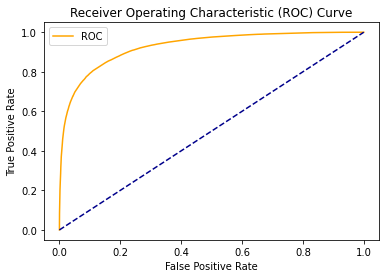

In [42]:
plot_roc_curve(fpr, tpr)

Y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

In [44]:
cm

array([[44589,  4256],
       [ 6347, 21608]])

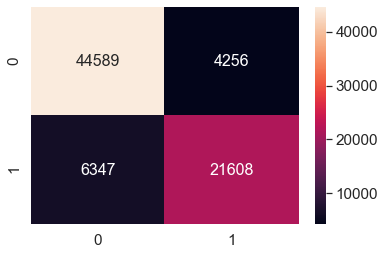

In [45]:
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, annot_kws={"size": 16},fmt='g') 

plt.show()